In [15]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt

os.chdir("/Users/jacobrichards/Desktop/DS_DA_Projects/2-Marketing_Prediction")

data = pd.read_csv("data.csv", na_values=["", "NA"])

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [8, 6]  # Default figure size
plt.rcParams['figure.dpi'] = 100  # Controls display resolution

In [16]:
print(data.head())

   id  age      dist       income gender marital_status  target
0   1   73  4.371654    90-99,999      M              S       1
1   2   89  1.582733  100-149,999      M            NaN       1
2   3   85  1.223810    10-19,999      F              S       1
3   4   76  2.962427    90-99,999      M              M       1
4   5   76  2.594408    10-19,999      M              S       1


# prepare data

In [17]:
import pandas as pd
import numpy as np

# Replace missing or empty values in columns 4, 5, 6 with "unknown"
data.iloc[:, [3, 4, 5]] = data.iloc[:, [3, 4, 5]].applymap(lambda x: "unknown" if pd.isna(x) or x == "" else x)

income_mapping = {
    "unknown": 55000,
    "Under $10k": 5000,
    "10-19,999": 15000,
    "20-29,999": 25000,
    "30-39,999": 35000,
    "40-49,999": 45000,
    "50-59,999": 55000,
    "60-69,999": 65000,
    "70-79,999": 75000,
    "80-89,999": 85000,
    "90-99,999": 95000,
    "100-149,999": 125000,
    "150 - 174,999": 162500,
    "175 - 199,999": 187500,
    "200 - 249,999": 225000,
    "250k+": 250000
}
data["income"] = data["income"].map(income_mapping).astype(int)

# Replace gender with 1 for male, 0 for female, and 0 for unknown
gender_mapping = {"M": 1, "F": 0, "unknown": 1}
data["gender"] = data["gender"].map(gender_mapping).astype(int)

# Replace marital_status with 1 for married, 0 for single, and 1 for unknown
marital_status_mapping = {"M": 1, "S": 0, "unknown": 1}
data["marital_status"] = data["marital_status"].map(marital_status_mapping).astype(int)

# Convert target to categorical values (0 or 1)
data["target"] = data["target"].astype(int)

# Convert distance (dist) column to integer
data["dist"] = data["dist"].astype(int)

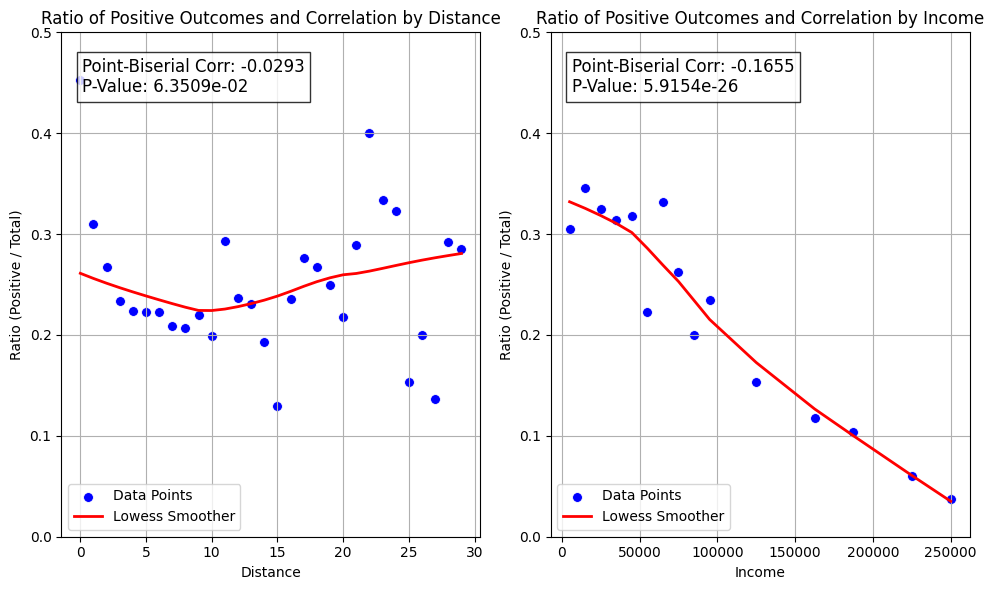

In [18]:
import seaborn as sns
from scipy.stats import pointbiserialr

def plot_ratio_positive_negative_with_corr(df, continuous_var, categorical_var='target', positive_value=1, negative_value=0):
    grouped = df.groupby([continuous_var, categorical_var]).size().reset_index(name='count')
    pivot = grouped.pivot(index=continuous_var, columns=categorical_var, values='count').fillna(0)
    
    positive_counts = pivot[positive_value] if positive_value in pivot.columns else 0
    total_counts = positive_counts + pivot[negative_value] if negative_value in pivot.columns else positive_counts
    ratio = positive_counts / (total_counts + 1e-9)
    
    plot_df = pd.DataFrame({continuous_var: ratio.index, 'ratio_positive_negative': ratio.values})
    return plot_df, *pointbiserialr(df[continuous_var], df[categorical_var])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

dist_plot_df, dist_corr, dist_p = plot_ratio_positive_negative_with_corr(data, 'dist', 'target')
sns.scatterplot(x='dist', y='ratio_positive_negative', data=dist_plot_df, color='blue', s=50, label='Data Points', ax=ax1)
sns.regplot(x='dist', y='ratio_positive_negative', data=dist_plot_df, scatter=False,
            lowess=True, color='red', line_kws={'lw': 2}, label='Lowess Smoother', ax=ax1)

ax1.text(0.05, 0.95, f'Point-Biserial Corr: {dist_corr:.4f}\nP-Value: {dist_p:.4e}', transform=ax1.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
ax1.set_title('Ratio of Positive Outcomes and Correlation by Distance')
ax1.set_xlabel('Distance')
ax1.set_ylabel('Ratio (Positive / Total)')
ax1.set_ylim(0, 0.50)
ax1.legend()
ax1.grid()

income_plot_df, income_corr, income_p = plot_ratio_positive_negative_with_corr(data, 'income', 'target')
sns.scatterplot(x='income', y='ratio_positive_negative', data=income_plot_df, color='blue', s=50, label='Data Points', ax=ax2)
sns.regplot(x='income', y='ratio_positive_negative', data=income_plot_df, scatter=False,
            lowess=True, color='red', line_kws={'lw': 2}, label='Lowess Smoother', ax=ax2)

ax2.text(0.05, 0.95, f'Point-Biserial Corr: {income_corr:.4f}\nP-Value: {income_p:.4e}', transform=ax2.transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
ax2.set_title('Ratio of Positive Outcomes and Correlation by Income')
ax2.set_xlabel('Income')
ax2.set_ylabel('Ratio (Positive / Total)')
ax2.set_ylim(0, 0.50)
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

Male is 1 and female is 0, married is 1 and single is 0, finally, response is 1 and no response is 0. 

In [19]:
print(data.head())

   id  age  dist  income  gender  marital_status  target
0   1   73     4   95000       1               0       1
1   2   89     1  125000       1               1       1
2   3   85     1   15000       0               0       1
3   4   76     2   95000       1               1       1
4   5   76     2   15000       1               0       1


In [20]:
# Create contingency table for gender/marital status vs target
predictors = pd.DataFrame({
    'Single': [data[(data['gender'] == 0) & (data['marital_status'] == 0)]['target'].mean(),
               data[(data['gender'] == 1) & (data['marital_status'] == 0)]['target'].mean()],
    'Married': [data[(data['gender'] == 0) & (data['marital_status'] == 1)]['target'].mean(),
                data[(data['gender'] == 1) & (data['marital_status'] == 1)]['target'].mean()]
}, index=['Female', 'Male'])

print("Proportion of Group that Responded") 
print(predictors)

Proportion of Group that Responded
          Single   Married
Female  0.227034  0.220790
Male    0.210339  0.302925


There is an interaction between gender and marital_status, so we will use some simple code to evaluate the model on all possible interaction terms and see which does best. 

the association between age and response fundamentally changes at age 82, we have to restructure the data some how so that we can model these two age groups distinctly in the effect they have on response

In [21]:
data['age_lt80'] = np.where(data['age'] < 80, data['age'], 82)
data['age_ge80'] = np.where(data['age'] >= 80, data['age'] - 82, 0)
print(data.head())

   id  age  dist  income  gender  marital_status  target  age_lt80  age_ge80
0   1   73     4   95000       1               0       1        73         0
1   2   89     1  125000       1               1       1        82         7
2   3   85     1   15000       0               0       1        82         3
3   4   76     2   95000       1               1       1        76         0
4   5   76     2   15000       1               0       1        76         0


# Evaluate Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import roc_curve, auc, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import combinations

base_features = ['age_lt80', 'age_ge80', 'dist', 'income', 'gender', 'marital_status']
interaction_terms = [
    ('age_lt80', 'dist'), ('age_lt80', 'income'), ('age_lt80', 'gender'), ('age_lt80', 'marital_status'),
    ('age_ge80', 'dist'), ('age_ge80', 'income'), ('age_ge80', 'gender'), ('age_ge80', 'marital_status'),
    ('dist', 'income'), ('dist', 'gender'), ('dist', 'marital_status'),
    ('income', 'gender'), ('income', 'marital_status'), ('gender', 'marital_status')
]

results = []

for r in range(len(interaction_terms) + 1):
    for terms in combinations(interaction_terms, r):
        X = data[base_features].copy()
        
        for t1, t2 in terms:
            X[f'{t1}_{t2}'] = X[t1] * X[t2]
            
        y = data['target']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        model = sm.Logit(y_train, sm.add_constant(X_train)).fit(disp=0)
        y_pred_proba_test = model.predict(sm.add_constant(X_test))
        
        test_data = pd.DataFrame({'target': y_test, 'predicted_probs': y_pred_proba_test})
        test_data_sorted = test_data.sort_values('predicted_probs', ascending=False)
        
        total_pos = test_data_sorted['target'].sum()
        n_rows = len(test_data_sorted)
        cutoff_index = int(0.4 * n_rows)
        lift_at_40 = test_data_sorted.iloc[:cutoff_index]['target'].sum() / total_pos * 100
        
        results.append({
            'num_interactions': len(terms),
            'interactions': terms,
            'lift_at_40': lift_at_40
        })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('lift_at_40', ascending=False)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("\nTop 10 interaction combinations by lift at 40%:")
display(results_df.head(10))


Top 10 interaction combinations by lift at 40%:


,num_interactions,interactions,lift_at_40
3402,5,"((age_ge80, income), (dist, income), (dist, gender), (dist, marital_status), (income, gender))",62.211982
1456,4,"((dist, income), (dist, gender), (dist, marital_status), (income, gender))",62.211982
6261,6,"((age_lt80, marital_status), (dist, income), (dist, gender), (dist, marital_status), (income, gender), (gender, marital_status))",61.751152
6427,6,"((age_ge80, income), (age_ge80, marital_status), (dist, income), (dist, gender), (dist, marital_status), (income, gender))",61.751152
5465,6,"((age_lt80, income), (age_ge80, income), (age_ge80, marital_status), (dist, income), (dist, marital_status), (income, gender))",61.751152
6195,6,"((age_lt80, marital_status), (age_ge80, income), (dist, income), (dist, gender), (dist, marital_status), (income, gender))",61.751152
3206,5,"((age_lt80, marital_status), (dist, income), (dist, gender), (dist, marital_status), (income, gender))",61.751152
3452,5,"((age_ge80, marital_status), (dist, income), (dist, gender), (dist, marital_status), (income, gender))",61.751152
6321,6,"((age_ge80, dist), (age_ge80, income), (dist, income), (dist, gender), (dist, marital_status), (income, gender))",61.290323
6305,6,"((age_ge80, dist), (age_ge80, income), (age_ge80, marital_status), (dist, income), (dist, marital_status), (income, gender))",61.290323


Yield at 40%: 62.2%


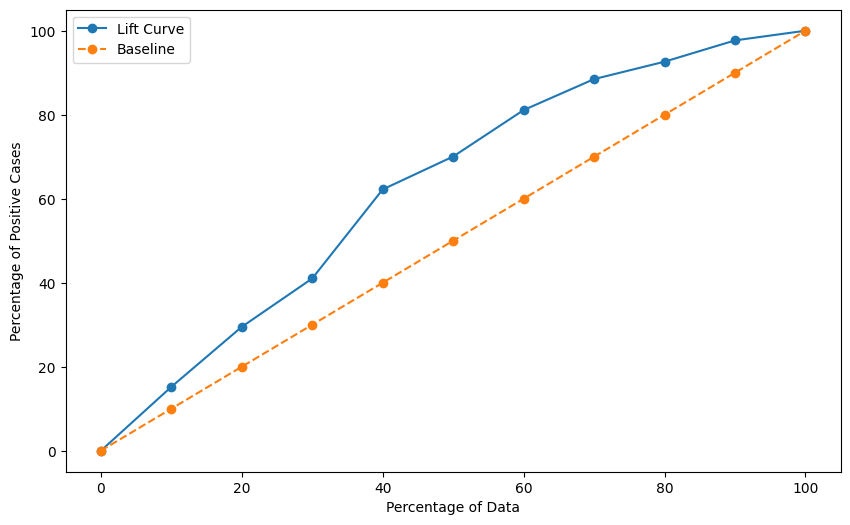

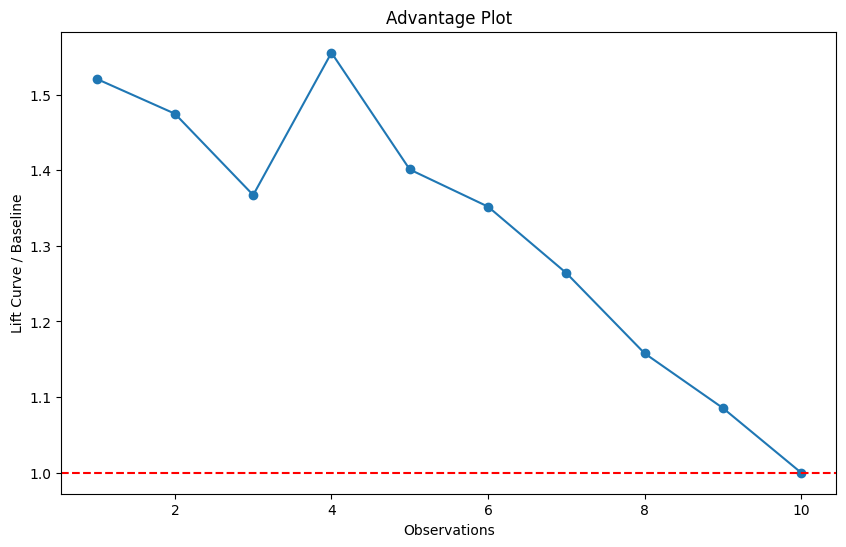


Top 10 observations by predicted probability:


,target,predicted_probs
1405,0,0.573828
279,1,0.557124
2586,1,0.552899
3331,1,0.551616
1211,1,0.549860
3379,0,0.541807
184,0,0.541584
893,0,0.535028
2682,0,0.532010
63,0,0.525651



Bottom 10 observations by predicted probability:


,target,predicted_probs
976,0,0.030603
2335,0,0.030217
3284,0,0.029970
1532,0,0.025576
538,0,0.023903
1916,0,0.023194
990,0,0.020209
3594,0,0.020071
3052,0,0.016611
2476,0,0.010878


In [23]:
best_terms = results_df.iloc[0]['interactions']

X = data[base_features].copy()
for t1, t2 in best_terms:
    X[f'{t1}_{t2}'] = X[t1] * X[t2]

y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = sm.Logit(y_train, sm.add_constant(X_train)).fit(disp=0)
y_pred_proba_test = model.predict(sm.add_constant(X_test))

test_data = pd.DataFrame({'target': y_test, 'predicted_probs': y_pred_proba_test})
test_data_sorted = test_data.sort_values('predicted_probs', ascending=False)

total_pos = test_data_sorted['target'].sum()
n_rows = len(test_data_sorted)
deciles = np.linspace(0, n_rows, 11, dtype=int)
lift_curve = [test_data_sorted.iloc[:i]['target'].sum() / total_pos * 100 for i in deciles]
baseline = np.linspace(0, 100, 11)

print(f'Yield at 40%: {lift_curve[4]:.1f}%')

plt.figure(figsize=(10, 6))
plt.plot(baseline, lift_curve, marker='o', label='Lift Curve')
plt.plot(baseline, baseline, linestyle='--', marker='o', label='Baseline')
plt.xlabel('Percentage of Data')
plt.ylabel('Percentage of Positive Cases')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(11), np.array(lift_curve) / baseline, marker='o')
plt.axhline(y=1, linestyle='--', color='r')
plt.xlabel('Observations')
plt.ylabel('Lift Curve / Baseline')
plt.title('Advantage Plot')
plt.show()

print("\nTop 10 observations by predicted probability:")
display(test_data_sorted.head(10))

print("\nBottom 10 observations by predicted probability:")
display(test_data_sorted.tail(10))


If the advantage chart shows that from left to right the curve is directly least to greatest advantage then the model is as optimized as possible 